In [72]:
from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import deque
from sklearn.utils import shuffle
import math as mt
from sklearn.datasets import make_blobs

In [73]:
import warnings
warnings.filterwarnings("ignore")

In [74]:
import pandas as pd
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             r2_score)

def evaluate_regression(y_true, y_pred, use_log = False):
    """Evaluate regression model performance.    
        Args:        
            y_true (array): Ground truth values.        
            y_pred (array): Predicted values.    
        Returns:        
            dict: Dictionary containing evaluation metrics.    """    
    metrics = {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred, squared=False),
        'r2': r2_score(y_true, y_pred)
    }
    if use_log:
        metrics['msle'] = mean_squared_log_error(y_true, y_pred)
    return metrics

def evaluate_classification(y_true, y_pred, labels = None):
    """    Evaluate classification model performance.    
            Args:        
                y_true (array): Ground truth values.        
                y_pred (array): Predicted values.        
                labels (list): List of labels to index the matrix.    
            Returns:        
                accuracy (float): Accuracy score.        
                report (pd.DataFrame): Classification report.        
                confusion_matrix (pd.DataFrame): Confusion matrix.    """    
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_true, y_pred), labels, labels)
    return accuracy, report, confusion

In [75]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

def plot_data(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

def plot_decision_boundary(model, X, y):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0]) + 0.25, 50)
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1]) + 0.25, 50)
    xx, yy = np.meshgrid(x_span, y_span)
    xx_, yy_ = xx.ravel(), yy.ravel()
    grid = np.c_[xx_, yy_]
    pred_func = model.predict_proba(grid)[:,0]
    z = pred_func.reshape(xx.shape)
    c = plt.contourf(xx, yy, z, cmap="RdYlGn")
    plt.colorbar(c)
    colors = list(mcolors.TABLEAU_COLORS.keys())
    color_values = [colors[int(label)] for label in y]
    plt.scatter(X[:, 0], X[:, 1], marker="x", c=color_values)

# Neural Nework

In [76]:
class NeuralNet:
    def __init__(self, layers_dims = [20] , activation_functions = ['ReLU','sigmoid'], normalize = True, learning_rate = 0.01, num_iter = 30000,
                 num_iter_cost_not_changed = 10, mini_batch_size = 64,regularization_param = 0.1, precision_cost_not_changed = pow(10,(-6)) ):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_dims = layers_dims #output layer not included!
        self.activation_functions = activation_functions
        self.num_iter_cost_not_changed = num_iter_cost_not_changed
        self.precision_cost_not_changed = precision_cost_not_changed
        self.mini_batch_size = mini_batch_size
        self.regularization_param = regularization_param
        # Multiclass classification
        self.output_dim = 1
        self.use_softmax = False

        self.cache = {}
        self.grads = {}
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def derivative_sigmoid(self,Z):
        a = self.__sigmoid(Z)
        return np.multiply(a,(1-a))
    
    def tanh(self, Z):
        return (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) - np.exp(-Z))
    
    def derivative_tanh(self, Z):
        a = self.tanh(Z)
        return 1 - np.multiply(a,a)
    
    def ReLU(self, Z):
        return np.maximum(0,Z)
    
    def derivative_ReLU(self,Z):
        return np.where(Z < 0, 0, 1)
    
    def leaky_ReLU(self,Z):
        return np.maximum(0.01*Z,Z)
    
    def derivative_leaky_ReLU(self,Z):
        return np.where(Z < 0, 0.01, 1)
    
    def softmax(self,Z):
        # print('Z: ',Z)
        # print('expZ',np.exp(Z))
        #Z = np.exp(Z)
        return np.exp(Z)/np.sum(np.exp(Z),axis=1,keepdims=True)
    
    def derivative_softmax(self,Z):
        length = len(Z)
        der_Z = np.zeros((length,length))
        a = self.softmax(Z)
        for i in range(length):
            for j in range(length):
                if(i == j):
                    der_Z[i,j] = a[i,j]*(1 - a[i,j])
                else:
                    der_Z[i,j] = - a[i,j]*a[i,j]
        return der_Z
    
    def activation_fun(self,Z,l):
        fun_name = self.activation_functions[l-1]
        if (fun_name == 'sigmoid'):
            return self.__sigmoid(Z)
        elif (fun_name == 'tanh'):
            return self.tanh(Z)
        elif (fun_name == 'ReLU'):
            return self.ReLU(Z)
        elif (fun_name == 'leaky ReLU'):
            return self.leaky_ReLU(Z)
        else:
            print('Incorrect activation function name! ')
        return 1
    
    def derivative_activation_fun(self,Z,l):
        fun_name = self.activation_functions[l-1]
        if (fun_name == 'sigmoid'):
            return self.derivative_sigmoid(Z)
        elif (fun_name == 'tanh'):
            return self.derivative_tanh(Z)
        elif (fun_name == 'ReLU'):
            return self.derivative_ReLU(Z)
        elif (fun_name == 'leaky ReLU'):
            return self.derivative_leaky_ReLU(Z)
        else:
            print('Incorrect activation function name! ')
        return 1
    
    def __initialize_parameters(self,n_x): 
        np.random.seed(3)
        L = len(self.layers_dims) + 1 

        self.cache[f"W{1}"] = np.random.randn(self.layers_dims[0], n_x) * 0.01
        self.cache[f"b{1}"] = np.zeros((self.layers_dims[0], 1))
        #self.cache[f"b{1}"] = [0]*self.layers_dims[0]


        for l in range(2, L):
            self.cache[f"W{l}"] = np.random.randn(self.layers_dims[l-1], self.layers_dims[l-2]) * 0.01
            self.cache[f"b{l}"] = np.zeros((self.layers_dims[l-1], 1))
            #self.cache[f"b{1}"] = [0]*self.layers_dims[l-1]

        # num of neurons in the last layer = output_dim!
        self.cache[f"W{L}"] = np.random.randn(self.output_dim, self.layers_dims[L-2]) * 0.01
        self.cache[f"b{L}"] = np.zeros((self.output_dim,1))
        #self.cache[f"b{L}"] = [0]*self.output_dim

        # print('\nInitialize:')
        # for l in range(1, L):
        #     print('\nl = ',l)
        #     W = self.cache[f"W{l}"]
        #     b = self.cache[f"b{l}"]
        #     print('W = ',W.shape)
        #     print('b = ',b.shape)

        
    def __forward_propagation(self, X):
        A = X
        L = len(self.layers_dims) + 1

        for l in range(1, L+1):
            W = self.cache[f"W{l}"]
            b = self.cache[f"b{l}"]
            Z = np.dot(W, A) + b
            if(l == L):
                if(self.use_softmax):
                    A = self.softmax(Z)
                    # print('Using softmax')
                    # print('A0',A[0,0])
                    # print('A1',A[1,0])
                    # print('A2',A[2,0])
                    # print('finished usinf softmax')
                else:
                    A = self.__sigmoid(Z)
            else:
                A = self.activation_fun(Z,l)
            self.cache[f"W{l}"] = W
            self.cache[f"b{l}"] = b
            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A
            # print('\nl = ',l)
            # print('W = ',W.shape)
            # print('b = ',b.shape)
            # print('Z = ',Z.shape)
            # print('A = ',A.shape)

        return A, self.cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        C = Y.shape[0]
        J = 0
        
        #---working-------------------------------
        if(self.use_softmax):
            for i in range(0,m):
                for j in range(0,self.output_dim):
                    J += Y[j,i]* np.log(A[j,i]+1e-8)
                    #print(J)
            # res = np.sum(Y*np.log(A + 1e-8))
            J = -(1 / m) * J
        else:
            res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
            J = -(1 / m) * np.sum(res)
        
        #------------------------------------------
        #res = np.zeros(self.output_dim+1)
        # for i in range(0,m):
        #     for j in range(0,self.output_dim):
        #         J += Y[j,i]* np.log(A[j,i])
        # # J = np.sum(Y*np.log(A +1e-8))
        # J = -1/m *J
        # print(J)
        # print(J/J0)
        #------Regularization----------------
        sum_norm = 0
        L = len(self.layers_dims) + 1
        for l in range(1,L+1):
            Wl = self.cache[f"W{l}"]
            # norm^2 ! fro = (...)^1/2
            sum_norm += pow(np.linalg.norm(Wl,'fro'),2)
        J +=  ( self.regularization_param / (2*m)) * sum_norm 
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        L = len(self.layers_dims) + 1

        WL = self.cache[f"W{L}"]
        bL = self.cache[f"b{L}"]
        ZL = self.cache[f"Z{L}"]
        AL = self.cache[f"A{L}"]
        AL_1 = self.cache[f"A{L-1}"]
        

        dAL = (-np.divide(Y, AL+ 1e-8) + np.divide(1-Y, 1-AL+ 1e-8))

        dZL = AL - Y
        dWL = 1. / m * np.dot(dZL, AL_1.T)
        dbL = 1. / m * np.sum(dZL, axis = 1, keepdims = True)
        dAL_1 = np.dot(WL.T,dZL)

        self.grads[f"dA{L}"] = dAL
        self.grads[f"dZ{L}"] = dZL
        self.grads[f"dW{L}"] = dWL
        self.grads[f"db{L}"] = dbL
        self.grads[f"dA{L-1}"] = dAL_1

        for l in reversed(range(1,L)):
            self.grads[f"dZ{l}"] = np.multiply(self.grads[f"dA{l}"], self.derivative_activation_fun(self.cache[f"Z{l}"],l))
            if l !=  1:
                self.grads[f"dW{l}"] = 1. / m * np.dot(self.grads[f"dZ{l}"], self.cache[f"A{l-1}"].T)
            else:
                self.grads[f"dW{l}"] = 1. / m * np.dot(self.grads[f"dZ{l}"], X.T)
            self.grads[f"db{l}"] = 1. / m * np.sum(self.grads[f"dZ{l}"], axis = 1, keepdims = True)
            if l != 1:
                self.grads[f"dA{l-1}"] = np.dot(self.cache[f"W{l}"].T, self.grads[f"dZ{l}"])
      
        return self.grads
    
    def __update_parameters(self, grads):

        L = len(self.layers_dims) + 1
        learning_rate = self.learning_rate

        for l in range(1, L+1):
            WL = self.cache[f"W{l}"]
            bL = self.cache[f"b{l}"]
            dWL = self.grads[f"dW{l}"] 
            dbL = self.grads[f"db{l}"]
            self.cache[f"W{l}"] = WL - learning_rate * dWL
            self.cache[f"b{l}"] = bL - learning_rate * dbL
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        last_cost = 0
        iter_cost_not_changed = 0
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        if(Y.shape[0] != 1):
            self.output_dim = Y.shape[0]
            self.use_softmax = True
        
        self.__initialize_parameters(n_x)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            # print(A.shape)
            # print('A0',A[0,0])
            # print('A1',A[1,0])
            # print('A2',A[2,0])

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, self.cache)

            self.__update_parameters(grads)
            
            # cost not changed
            if (abs(last_cost-cost) < self.precision_cost_not_changed ):
                iter_cost_not_changed  = iter_cost_not_changed + 1
            else:
                iter_cost_not_changed = 0

            last_cost = cost

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
                print(iter_cost_not_changed)

            if i % 1000 == 0:
                costs.append(cost)

            if(iter_cost_not_changed == self.num_iter_cost_not_changed):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()

    def fit_with_mini_batch(self, X_vert, Y_vert, print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        last_cost = 0
        
        m = X.shape[1]
        n_x = X.shape[0]
        k = self.mini_batch_size
        p = mt.ceil(m / k)
        
        if(Y.shape[0] != 1):
            self.output_dim = Y.shape[0]
            self.use_softmax = True

        
        self.__initialize_parameters(n_x)

        for i in range(self.num_iter):
            #mix dataset
            X, Y = shuffle(X.T, Y.T)
            X = X.T
            Y = Y.T

            for t in range(0,p):
                X_mb = X[:,t*k:(t+1)*k]
                Y_mb = Y[:,t*k:(t+1)*k]
                # print(X_mb.shape)
                # print(Y_mb.shape)

                A, cache = self.__forward_propagation(X_mb)

                cost = self.compute_cost(A, Y_mb)

                grads = self.__backward_propagation(X_mb, Y_mb, self.cache)

                self.__update_parameters(grads)
                
                # cost not changed
                if (abs(last_cost-cost) < self.precision_cost_not_changed ):
                    iter_cost_not_changed  = iter_cost_not_changed + 1
                else:
                    iter_cost_not_changed = 0

                last_cost = cost

                if print_cost and i % 1000 == 0:
                    print("{}-th iteration: {}".format(i, cost))
                    print(iter_cost_not_changed)

                if i % 1000 == 0:
                    costs.append(cost)

                if(iter_cost_not_changed == self.num_iter_cost_not_changed):
                    break


                # if print_cost:
                #     plt.plot(costs)
                #     plt.ylabel("Cost")
                #     plt.xlabel("Iteration, *1000")
                #     plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        if(self.use_softmax):
            return probs.T
        return np.column_stack((1 - probs.T, probs.T))
    
    def predict(self, X_vert):
        if (self.use_softmax):
            probs = self.predict_proba(X_vert)
            return np.argmax(probs,axis=1)
        positive_probs = self.predict_proba(X_vert)[:, 1]
        return (positive_probs >= 0.5).astype(int)   
    
    def test(self,Z):
        softmax_Z = self.softmax(Z)
        return softmax_Z


In [77]:
Z = [[5,4,2],[4,2,8],[4,4,1]]
nn = NeuralNet()
nn.test(Z)

array([[0.70538451, 0.25949646, 0.03511903],
       [0.01794253, 0.00242826, 0.97962921],
       [0.48785555, 0.48785555, 0.0242889 ]])

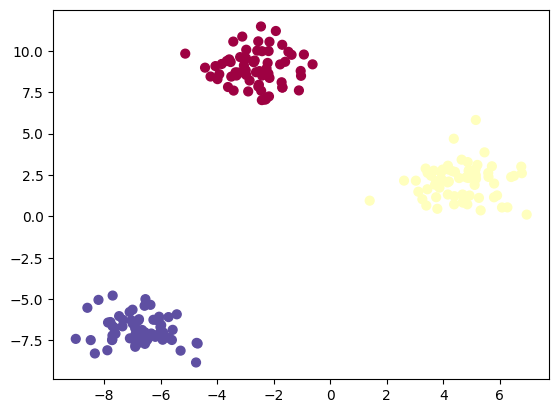

0-th iteration: 5.075166096232097
0
1000-th iteration: 5.075123565360994
1000
2000-th iteration: 5.075081827294139
2000
3000-th iteration: 5.075039803220667
3000
4000-th iteration: 5.074996409773351
4000
5000-th iteration: 5.074956581122182
5000
6000-th iteration: 5.074917644480682
6000
7000-th iteration: 5.074877556140142
7000
8000-th iteration: 5.074835736231098
8000
9000-th iteration: 5.074791704184713
9000
10000-th iteration: 5.074745711884785
10000
11000-th iteration: 5.074701044820755
11000
12000-th iteration: 5.074656185330436
12000
13000-th iteration: 5.0746078071136695
13000
14000-th iteration: 5.0745548137029095
14000
15000-th iteration: 5.074496656672923
15000
16000-th iteration: 5.0744327031320635
16000
17000-th iteration: 5.074362299133253
17000
18000-th iteration: 5.074284675755711
18000
19000-th iteration: 5.074199026928798
19000
20000-th iteration: 5.074104439438291
20000
21000-th iteration: 5.07399988498329
21000
22000-th iteration: 5.073884269118549
22000
23000-th ite

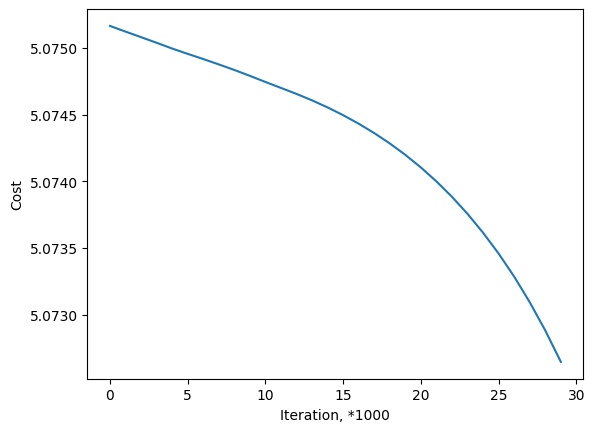

Accuracy: 
1.0
Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        13

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion: 
    0   1   2
0  12   0   0
1   0  15   0
2   0   0  13


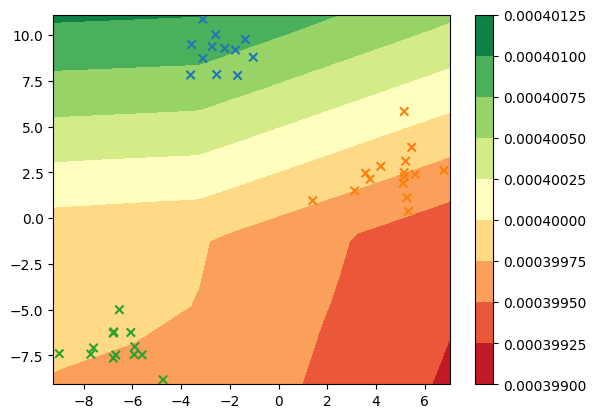

In [88]:
from sklearn.preprocessing import OneHotEncoder

X, y = make_blobs(n_samples=200, centers=3, n_features=2,random_state=42)

# X, y = make_classification(n_samples = 200, n_classes = 3, n_features = 3, 
#                            n_informative=3, n_redundant=0, random_state = 123,
#                            flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

enc = OneHotEncoder(sparse=False, categories='auto')
y_train_t = enc.fit_transform(y_train.reshape(len(y_train), -1))
y_test_t = enc.transform(y_test.reshape(len(y_test), -1))

nn = NeuralNet(learning_rate = 0.0001,layers_dims=[10],activation_functions=['ReLU'],num_iter_cost_not_changed=1000000)
nn.fit(X_train, y_train_t)

y_test_pred = nn.predict(X_test)

# y_train_arr = y_train.array
# y_train_arr =y_train_arr.reshape(-1,1)
# y_test_arr = y_test_pred.array
# y_test_arr =y_test_arr.reshape(-1,1)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
# plot_decision_boundary(nn, X_test, y_test)
# plt.show()

In [79]:
# Comments - tests
W = np.array([[1,1],[2,2]])
W_norm = np.linalg.norm(W,'fro')
print(W_norm*W_norm)
# add norm frobenius of W to cost function
# fro ^2 ?
N = np.zeros(1)
print(N)


10.000000000000002
[0.]


# Tests MY NN

In [80]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
#plot_data(X, y)
#plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet()
# nn.test(X_train,y_train)

# Симульовані дані 1

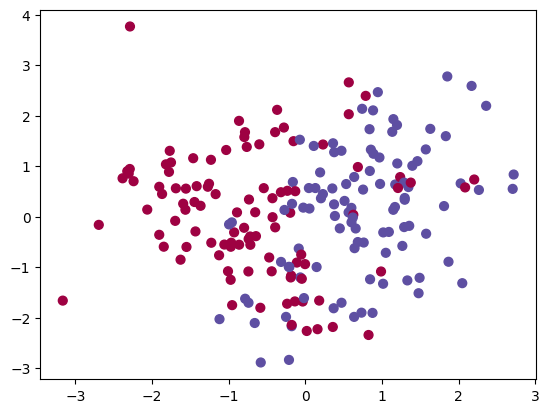

(160, 2)
0-th iteration: 0.6932287653845773
0
0-th iteration: 0.6924186687369521
0
0-th iteration: 0.6942713265364522
0
1000-th iteration: 0.6967913274652663
0
1000-th iteration: 0.6912692956564662
0
1000-th iteration: 0.6900597015227948
0
2000-th iteration: 0.6938813577824519
0
2000-th iteration: 0.6970408288332317
0
2000-th iteration: 0.685657276909472
0
3000-th iteration: 0.6913926354207597
0
3000-th iteration: 0.6909525117395515
0
3000-th iteration: 0.7009127935626575
0
4000-th iteration: 0.2934554513660651
0
4000-th iteration: 0.4932260812011581
0
4000-th iteration: 0.4591353947965672
0
5000-th iteration: 0.38210579180557824
0
5000-th iteration: 0.4271340993272504
0
5000-th iteration: 0.38546706468082187
0
6000-th iteration: 0.40146504108868514
0
6000-th iteration: 0.3890119120295178
0
6000-th iteration: 0.4226857147649953
0
7000-th iteration: 0.4111761238458472
0
7000-th iteration: 0.38036360824951226
0
7000-th iteration: 0.41893361695139175
0
8000-th iteration: 0.346387713798078

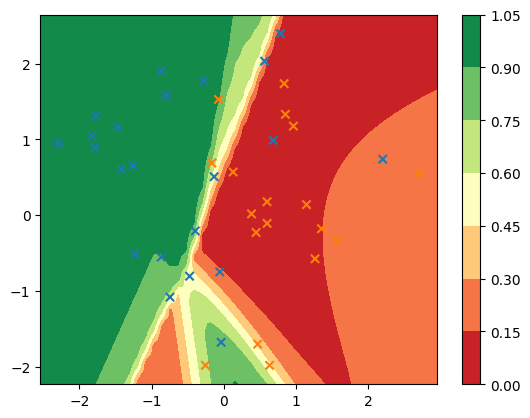

In [81]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)
print(X_train.shape)

nn = NeuralNet(learning_rate = 0.05,layers_dims=[20,20],activation_functions=['ReLU','sigmoid','sigmoid'],num_iter_cost_not_changed=1000000)
#nn.fit(X_train, y_train)
nn.fit_with_mini_batch(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 2

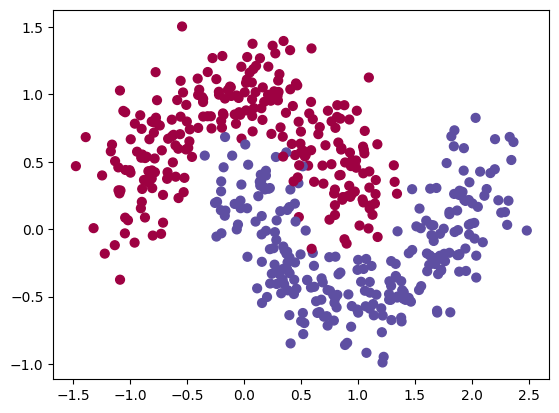

0-th iteration: 0.6935172945191639
0
1000-th iteration: 0.6925367309671343
997
2000-th iteration: 0.692015031546324
0
3000-th iteration: 0.2895837053777686
0
4000-th iteration: 0.2884014652832084
477
5000-th iteration: 0.28829958499085506
1477
6000-th iteration: 0.2884721986002922
2477
7000-th iteration: 0.28873276614112653
3477
8000-th iteration: 0.28902086045251324
4477
9000-th iteration: 0.2893108304786335
5477
10000-th iteration: 0.2895872536835884
6477
11000-th iteration: 0.2898338198789406
7477
12000-th iteration: 0.2900181260225573
8477
13000-th iteration: 0.29002061255089123
9477
14000-th iteration: 0.2755979720609422
0
15000-th iteration: 0.11157329135017785
0
16000-th iteration: 0.10896954625631047
432
17000-th iteration: 0.1092924708989214
1432
18000-th iteration: 0.1103695125591629
0
19000-th iteration: 0.11208551298583534
0
20000-th iteration: 0.11407682633030301
0
21000-th iteration: 0.11613978923162083
0
22000-th iteration: 0.11819229165522332
0
23000-th iteration: 0.120

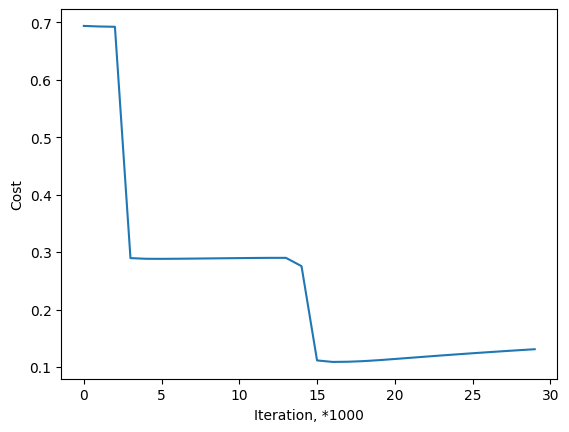

Accuracy: 
0.99
Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion: 
    0   1
0  43   0
1   1  56


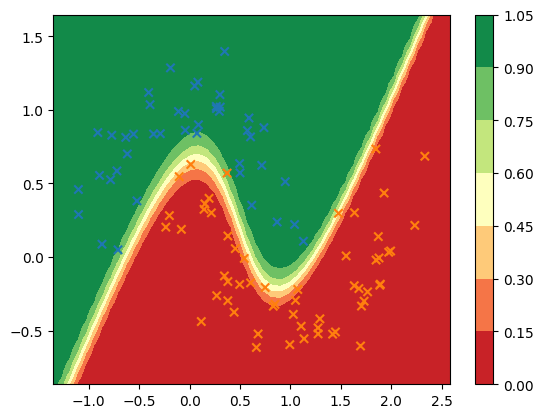

In [82]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(learning_rate = 0.5,layers_dims=[20,20],activation_functions=['sigmoid','sigmoid','sigmoid'],num_iter_cost_not_changed=10000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

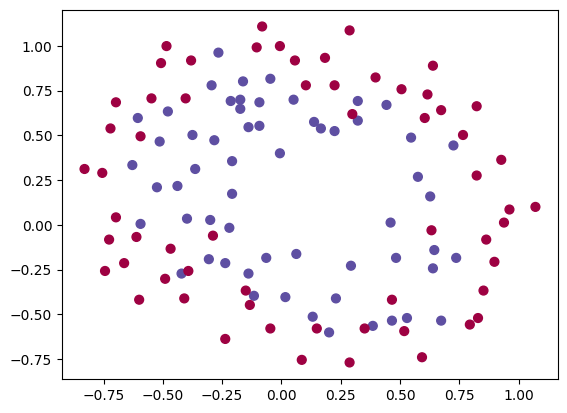

In [83]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("C:\\tests.csv")
X, y = df[data_columns].values, df[target_column].values

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

0-th iteration: 0.693410020026403
0
1000-th iteration: 0.6929465697354976
995
2000-th iteration: 0.6929467181250091
1995
3000-th iteration: 0.6929469213505919
2995
4000-th iteration: 0.6929471886190752
3995
5000-th iteration: 0.6929475330190797
4995
6000-th iteration: 0.6929479728255379
5995
7000-th iteration: 0.692948533482514
6995
8000-th iteration: 0.6929492506338064
7995
9000-th iteration: 0.692950174807625
8995
10000-th iteration: 0.6929513787429776
9995
11000-th iteration: 0.6929529689018756
10995
12000-th iteration: 0.6929551032239487
11995
13000-th iteration: 0.6929580159591892
12995
14000-th iteration: 0.6929620377169272
13995
15000-th iteration: 0.6929675176176312
14995
16000-th iteration: 0.6929740203806668
15995
17000-th iteration: 0.6929738454489728
16995
18000-th iteration: 0.6928824699918584
17995
19000-th iteration: 0.6912693100171198
0
20000-th iteration: 0.6878973859483376
313
21000-th iteration: 0.6863793945821228
0
22000-th iteration: 0.6829571952424678
0
23000-th i

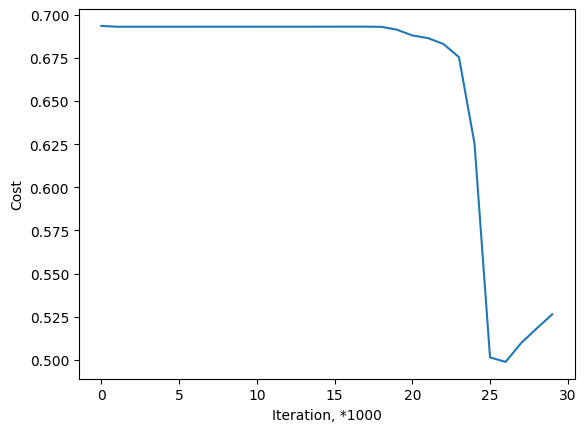

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.75      0.75      0.75        12

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24

Confusion: 
   0  1
0  9  3
1  3  9


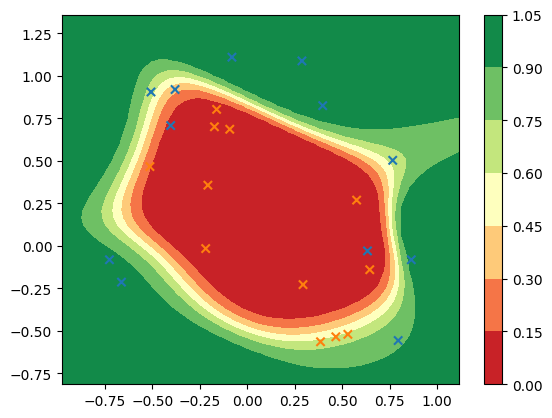

In [84]:
nn = NeuralNet(normalize = True, learning_rate = 0.3,layers_dims=[20,20],activation_functions=['sigmoid','sigmoid','sigmoid'], num_iter_cost_not_changed = 100000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.7916666666666666
Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

Confusion: 
    0  1
0  10  2
1   3  9


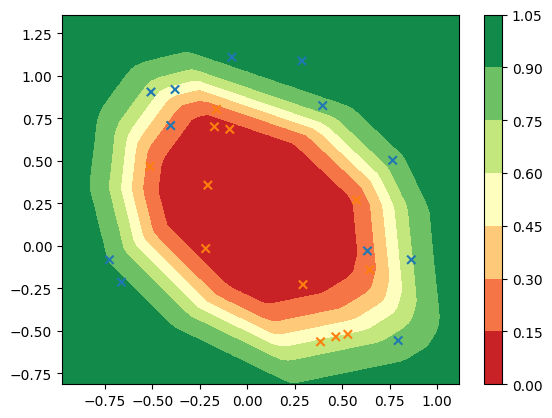

In [85]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

# Softmax tests

In [86]:
from sklearn.preprocessing import OneHotEncoder

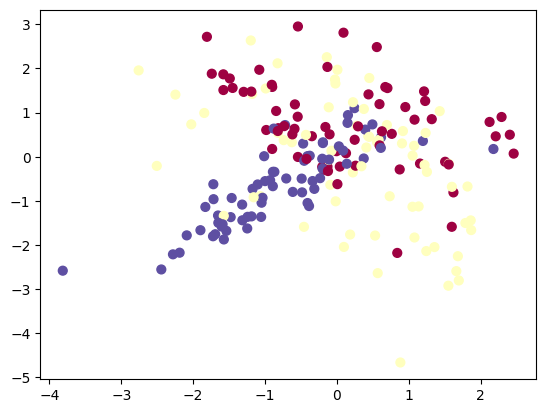

0-th iteration: 5.075268794987823
0
1000-th iteration: 9.235129818585042
0
2000-th iteration: 23.362669239506815
0
3000-th iteration: nan
0
4000-th iteration: nan
0
5000-th iteration: nan
0
6000-th iteration: nan
0
7000-th iteration: nan
0
8000-th iteration: nan
0
9000-th iteration: nan
0
10000-th iteration: nan
0
11000-th iteration: nan
0
12000-th iteration: nan
0
13000-th iteration: nan
0
14000-th iteration: nan
0
15000-th iteration: nan
0
16000-th iteration: nan
0
17000-th iteration: nan
0
18000-th iteration: nan
0
19000-th iteration: nan
0
20000-th iteration: nan
0
21000-th iteration: nan
0
22000-th iteration: nan
0
23000-th iteration: nan
0
24000-th iteration: nan
0
25000-th iteration: nan
0
26000-th iteration: nan
0
27000-th iteration: nan
0
28000-th iteration: nan
0
29000-th iteration: nan
0


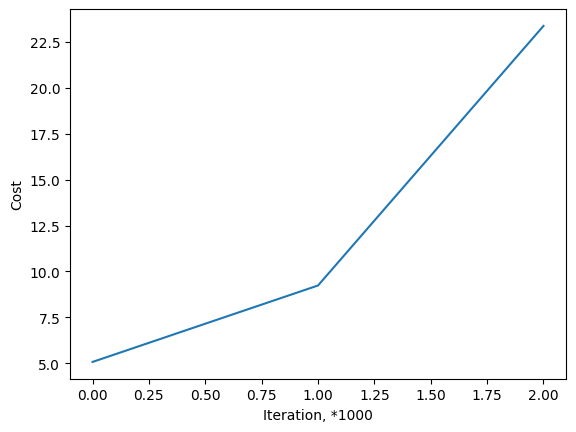

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [87]:
X, y = make_blobs(n_samples=200, centers=3, n_features=2,random_state=42)

# X, y = make_classification(n_samples = 200, n_classes = 3, n_features = 3, 
#                            n_informative=3, n_redundant=0, random_state = 123,
#                            flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

enc = OneHotEncoder(sparse=False, categories='auto')
y_train_t = enc.fit_transform(y_train.reshape(len(y_train), -1))
y_test_t = enc.transform(y_test.reshape(len(y_test), -1))

nn = NeuralNet(learning_rate = 0.0001,layers_dims=[10],activation_functions=['ReLU'],num_iter_cost_not_changed=1000000)
nn.fit(X_train, y_train_t)

y_test_pred = nn.predict(X_test)

# y_train_arr = y_train.array
# y_train_arr =y_train_arr.reshape(-1,1)
# y_test_arr = y_test_pred.array
# y_test_arr =y_test_arr.reshape(-1,1)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
# plot_decision_boundary(nn, X_test, y_test)
# plt.show()